#__PRACTICAL SESSION 2__ Supervised DEEP LEARNING#

The dataset is a _subset_ of CIFAR10 (a very popular dataset in Machine Learning) with only 4 classes: **BIRD**, **CAT**, **FROG**, **HORSE**. We will call our dataset **CIFAR4**. It is composed of 24000 images from 4 types of animals.

Input data are square color images (RGB). The size of a picture is 32x32. So we have an input tensor of size [32,32,3]. Each pixel has a red, green and blue UINT8 values, i.e. in [0,255].   

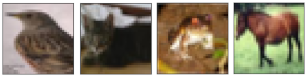

The dataset is available on [**ECAMPUS**](https://ecampus.emse.fr/course/section.php?id=7365)

The main objective is to train different deep neural network models to classify an image into one of the 4 classes.

The goal of this practical session is to experiment! Everything you need is easily available in the TENSORFLOW documentation that contains many examples.

#BONUS STRIKE 🎳

You can make additional experiences. In that case, please add bonus works at the end of your notebook in the __[BONUS]__ section.

Bonus works could bring bonus points on the global note for the practical sessions **_if and only if_** all the mandatory jobs have been done correctly.


#IMPORT LIBS

We will use TENSORFLOW, the Deep Learning platform from Google.  

TensorFlow is easy to understand and the documentation and [tutorials](https://www.tensorflow.org/tutorials) are (very) useful when learning Deep Learning.


*I already know how to develop DL models and I want to use PyTorch instead. Is it possible?*

==> *YES.* [PYTORCH](https://pytorch.org/) (from Meta) is the other big reference for DL libraries. Note that, in that case, *it's your choice* and you must be *self-sufficient* in case of development issues.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# [WARNING] About the use of COLAB and GPU

_On the top-right of the colab environment, you can chose the execution environment ("Modify the execution type") between CPU and GPU (Nvidia T4). With a free google account, there is no limitation with the CPU-only mode. With the GPU, you have a limitation that is dynamically set by Google regarding the overall load on their infrastructure. Usually, it could be 1 hour per day._

_For this practical session, you can keep the CPU mode for the MLP part. For the CNN section, you can swith to the GPU mode if you consider the processing are too slow. But, be careful and not too GPU-enthusiast._

NB: You can check the CPU info with
`!cat /proc/cpuinfo`

In [2]:
#Get CPU info
!cat /proc/cpuinfo
#Get GPU info
#!nividia-smi

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.150
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

# DOWNLOAD AND CHECK THE DATASET [3 pts]

Data must be located in a ./data directory at the same level as this notebook


In [3]:
#IF YOU USE Google COLAB, you can mount your Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Create a 'data/' directory, put the numpy files and load. With Colab case, create 'data' here:
X_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_X.npy")
Y_cifar4=np.load("/content/drive/MyDrive/Colab Notebooks/data/CIFAR4_Y.npy")
print(np.shape(X_cifar4))
print(np.shape(Y_cifar4))
nb_labels=4

(24000, 32, 32, 3)
(24000,)


**[QUESTION]** Display some images from X_cifar4 with the corresponding label

_NB:_ Since the pictures are very small, use `plt.figure(figsize=(2, 2), dpi=80)` before `plt.imshow()` to display something _"watchable"_.

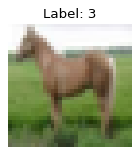

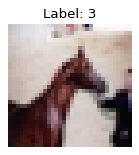

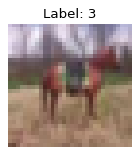

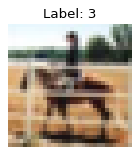

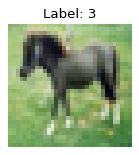

In [5]:
def display_images_with_labels(X, Y, nb_images=5):
    """
    Affiche nb_images d'images de X avec leurs étiquettes correspondantes.

    :param X: Tableau numpy contenant les images.
    :param Y: Tableau numpy contenant les étiquettes.
    :param nb_images: Nombre d'images à afficher.
    """
    for i in range(nb_images):
        plt.figure(figsize=(2, 2), dpi=80)  # Configurer la taille de la figure
        plt.imshow(X[20000+i])  # Afficher l'image
        plt.title(f"Label: {Y[20000+i]}")  # Ajouter le titre correspondant au label
        plt.axis('off')  # Supprimer les axes pour une visualisation plus claire
        plt.show()

# Appel de la fonction pour afficher des exemples
display_images_with_labels(X_cifar4, Y_cifar4, nb_images=5)


A pixel is an UINT8 value, so in [0;255]. We will normalize data in [0,1]:

In [6]:
print("First pixel (r,g,b) of the first image:", X_cifar4[0,0,0,:])
X = X_cifar4/255.0
print("Now in [0,1] ==> ", X[0,0,0,:])


First pixel (r,g,b) of the first image: [164 206  84]
Now in [0,1] ==>  [0.64313725 0.80784314 0.32941176]


For the labels **Y**, usually, we prefer to process "one-hot encodings" i.e., a vector with '0' everywhere except for the corresponding label where you have '1'.

Example : let's say you have 4 labels and 10 training data with the original Y:
```
Y=[0,1,1,3,3,3,2,2,1,0]
shape(Y)=[10,]
```
Then the "one-hot encoding" version of Y will be:

```
Y_onehot=
[1,0,0,0;
 0,1,0,0;
 0,1,0,0;
 0,0,0,1;
 0,0,0,1;
 0,0,0,1;
 0,0,1,0;
 0,0,1,0;
 0,1,0,0;
 1,0,0,0]
shape(Y_onehot)=[10,4]
```

**[QUESTION]** Use the tensorflow method [*tf.keras.utils.to_categorical()*](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to transform your Y_cifar4 into Y and check the shape of your new Y.

In [7]:
#Your code here
Y = tf.keras.utils.to_categorical(Y_cifar4, num_classes=4)
print(np.shape(Y))
print(Y[0])
print(Y[23999])

(24000, 4)
[1. 0. 0. 0.]
[0. 0. 0. 1.]


# CREATE A TRAINING/VALIDATION/TEST dataset [2 pt]

NB: This step is similar to the supervised section in TP1.

__[QUESTION]__ Use the SKLEARN method [train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) in order to create:

*   a TRAIN set (X_train,Y_train) _[advice: use 70% of the whole dataset]_
*   a VALIDATION set (X_val, Y_val) _[advice: 15%]_
*   a TEST set (X_test, Y_test) _[advice: 15%]_

Print the shape of the 3 datasets.

The TRAIN and VALIDATION sets will be used at training time. The TEST set will be used, after the training, at the inference time.

NOTE that we could only use a single VALIDATION/TEST set for both the training and the inference stages.

In [8]:
#Your code here
#CREATE A TRAINING/ VALIDATION/TEST dataset
from sklearn.model_selection import train_test_split

# Étape 1 : Diviser en TRAIN et TEMP (85% TRAIN + VALIDATION, 15% TEST)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Étape 2 : Diviser TRAIN + VALIDATION en TRAIN (70%) et VALIDATION (15%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1765, random_state=42)
# La proportion 0.1765 (~15/85) est utilisée pour diviser TRAIN+VALIDATION en ~70% TRAIN et ~15% VALIDATION.

# Afficher les dimensions des ensembles de données
print("\nDimensions après division :")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")



Dimensions après division :
X_train: (16799, 32, 32, 3), Y_train: (16799, 4)
X_val: (3601, 32, 32, 3), Y_val: (3601, 4)
X_test: (3600, 32, 32, 3), Y_test: (3600, 4)


[**QUESTION**] Why the train/val/test split is important in our case? What is the main interest of the validation data at training time?

[**ANSWER**] La division des données en ensembles d'entraînement, de validation et de test est très importante pour les raisons qui suivent:

  **Overfitting :**

    Si on évalue le modèle sur les mêmes données que celles utilisées pour l'entraînement, il risque de mémoriser les données plutôt que d'apprendre à généraliser.
    Cela donne une fausse impression de performance, car le modèle performe bien sur les données connues mais échoue sur de nouvelles données.

**Évaluer la généralisation :**

    L'ensemble de test est utilisé pour évaluer les performances finales du modèle sur des données totalement indépendantes.
    Cela donne une estimation réaliste de la performance du modèle en production.

**Ajuster les hyperparamètres :**

    L'ensemble de validation est utilisé pour ajuster les hyperparamètres sans biaiser l'évaluation finale.

L'intérêt principal des données de validation est de surveiller les performances du modèle : À chaque epoch, le modèle est évalué sur l'ensemble de validation. Cela permet de suivre la loss et l'accuracy sur des données non vues. Les performances sur le val set sont utilisées pour choisir les meilleurs hyperparamètres (taux d'apprentissage, nombre de couches, ...).

# MULTI-LAYER PERCEPTRON (MLP) MODEL [12 pts]

## Analyse of a MLP code [6pts]

It's time to build our first deep neural network...

Below, we provide a small code **THAT IS NOT WORKING**, because something are missing or wrong.

The model is a very simple MLP with only one hidden layer (20 neurons). So we have :   
```
x --> "input" layer ==> hidden layer ==> output layer --> ̂y   
```
Have a look at the code, and understand how it works.

In [9]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(10, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=4
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,670 (240.90 KB)

 Trainable params: 61,670 (240.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 10)

**[QUESTION]**

   - (1) What is the activation function for the hidden layer?
   - (2) What is the most used activation function in deep learning?
   - (3) How many time an image sample will be used during the training?
   - (4) How many training iterations (i.e., params update) in total will be processed?

**[ANSWER]** **(1)** - The activation function for the hidden layer is tanh.
**(2)** - The most used activation function is reLu, because it avoids vanishing gradient issues common with sigmoid or tanh.
**(3)** - An image will be used the number of epochs, wich is 4 here, during the training. (once per epoch)
**(4)** -
Total Iterations=Number of Training Samples​ × Number of Epochs / Batch Size.

The total number of training iterations is 0.7 * 24000 * 4 / 100 = 672.

**[QUESTION]**

   - (1) Regarding the previous questions, copy and change the code above to make it runs on **10 EPOCHS**. Comment the resulting performance of the model.
   - (2) For our MLP, why do we need this line `x = tf.keras.layers.Flatten()(inputs)` ?
   - (3) Give the calculation of the number of trainable parameters
  
   

In [10]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32,32,3)) #my input layer
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(4, activation='softmax')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

#PRINT A SUMMARY OF THE ARCHITECTURE OF MY MODEL WITH THE NUMBER OF TRAINABLE PARAMETERS
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=10
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │          61,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              84 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,544 (240.41 KB)

 Trainable params: 61,544 (240.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3301 - loss: 1.4146 - val_accuracy: 0.4707 - val_loss: 1.2233
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4607 - loss: 1.2174 - val_accuracy: 0.4979 - val_loss: 1.1740
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5004 - loss: 1.1627 - val_accuracy: 0.4813 - val_loss: 1.1800
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5162 - loss: 1.1377 - val_accuracy: 0.5204 - val_loss: 1.1297
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5194 - loss: 1.1242 - val_accuracy: 0.5196 - val_loss: 1.1247
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5251 - loss: 1.1136 - val_accuracy: 0.5137 - val_loss: 1.1186
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5322 - loss: 1.0956 - val_accuracy: 0.4982 - val_loss: 1.1543
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5372 - loss: 1.0895 - val_accuracy: 0

**[ANSWER]**
**(1)** -
The model's performance on both the training and validation sets improves over the epochs, but the accuracy remains relatively low (~55-58%). This suggests that the model might be underfitting, possibly due to the simplicity of the architecture (only one hidden layer with 20 neurons).

**(2)** -  The Flatten layer converts the 3D input shape of (32, 32, 3) into a 1D vector of size 32 * 32 * 3 = 3072.
Indeed, Dense layers require a 1D input vector. Flattening transforms the multi-dimensional input into a format suitable for the Dense layer to process.

**(3)** - Input size: 3072 (from Flatten layer).
Hidden Layer : 20 neurons.
Output size: 4 neurons.
Total number of trainable parameters is ( 3072 * 20 ) + 20 (nb of bias) + (20 * 4) + 4 (nb of bias) = 61544.


It is always good to have a look on the training curves. That is the role of the "**training_history**" object that we defined in the code as the output of the **fit** method. In this object, we collect all the loss and metric values after each epoch.

You can use the following **method** to display the train/val curves (loss and accuracy):

In [11]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

**[QUESTION]** Display the training curves from your MLP model.



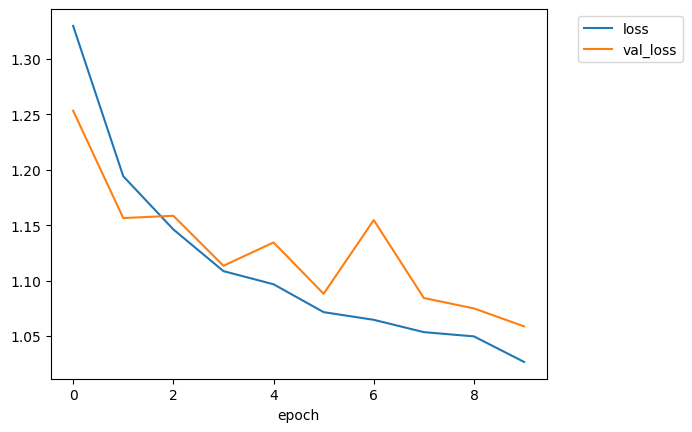

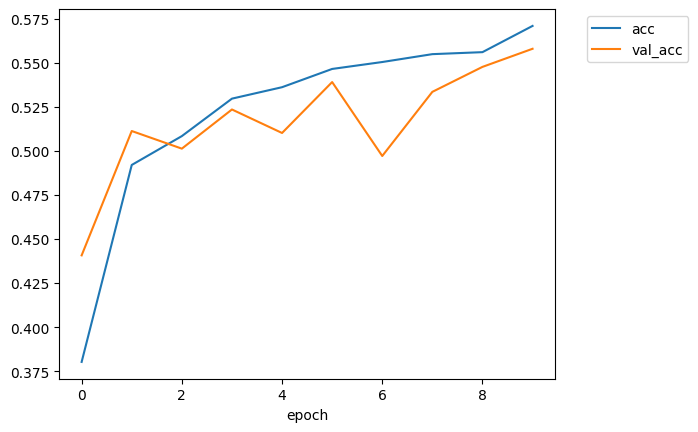

In [ ]:
#Your code here
display_training_curves(training_history)

## Improvements and overfitting [6 pts]

**[QUESTION]** Use the previous MLP code to build your own model and try to reach a better accuracy performance (e.g., above/around 60%, both train and test)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,812 (1.54 MB)

 Trainable params: 403,812 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.2606 - loss: 1.4490 - val_accuracy: 0.2527 - val_loss: 1.3851
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2549 - loss: 1.3843 - val_accuracy: 0.3593 - val_loss: 1.3740
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3504 - loss: 1.3698 - val_accuracy: 0.3374 - val_loss: 1.3595
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3653 - loss: 1.3508 - val_accuracy: 0.3832 - val_loss: 1.3329
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3910 - loss: 1.3203 - val_accuracy: 0.4038 - val_loss: 1.3026
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4159 - loss: 1.2863 - val_accuracy: 0.4218 - val_loss: 1.2692
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4354 - loss: 1.2496 - val_accuracy: 0.4427 - val_loss: 1.2436
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4477 - loss: 1.2268 - val_accuracy: 0.4404 - 

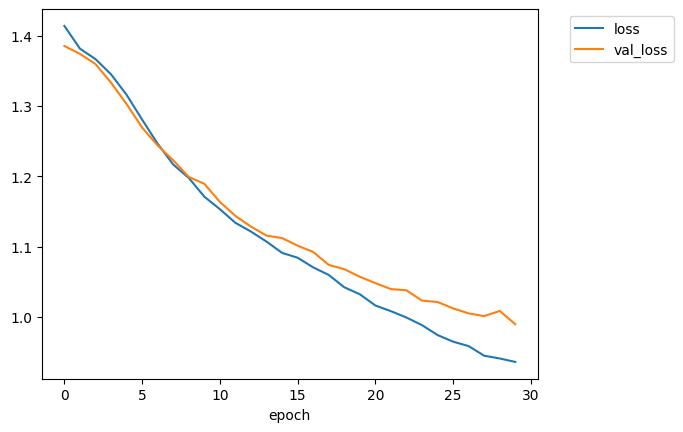

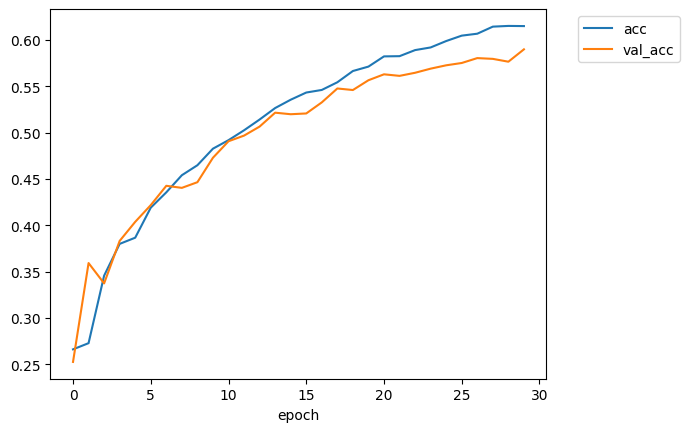

In [12]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
# First, define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32, 32, 3))  # Input layer
x = tf.keras.layers.Flatten()(inputs)  # Flatten input into a 1D vector
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)  # First hidden layer
x = tf.keras.layers.Dense(64, activation='sigmoid')(x)  # Second hidden layer
x = tf.keras.layers.Dense(32, activation='sigmoid')(x)  # Third hidden layer
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer

# Define the model
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

# Print a summary of the architecture
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs = 30
batch_size = 1000
training_history = my_mlp_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    batch_size=batch_size
)

# COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)
display_training_curves(training_history)

**[QUESTION]** For illustration/educational purpose, use the code of your last model and adapt it so that your model clearly **OVERFITS**.

We need to see the overfitting issue on the training curve!

(Think about the reasons of overfitting?)

Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,738,116 (6.63 MB)

 Trainable params: 1,738,116 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2939 - loss: 1.4062 - val_accuracy: 0.3968 - val_loss: 1.2640
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4462 - loss: 1.2213 - val_accuracy: 0.4582 - val_loss: 1.2214
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4934 - loss: 1.1515 - val_accuracy: 0.5237 - val_loss: 1.0971
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5375 - loss: 1.0722 - val_accuracy: 0.5537 - val_loss: 1.0582
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5588 - loss: 1.0387 - val_accuracy: 0.5546 - val_loss: 1.0477
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5860 - loss: 0.9961 - val_accuracy: 0.5623 - val_loss: 1.0370
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9840 - val_accuracy: 0.5807 - val_loss: 1.0179
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5961 - loss: 0.9664 - val_acc

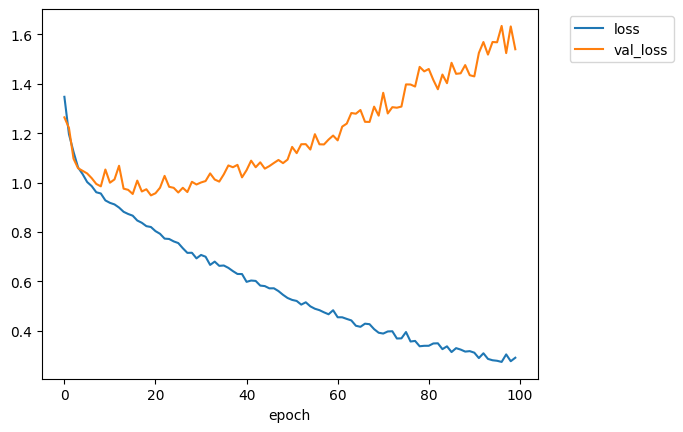

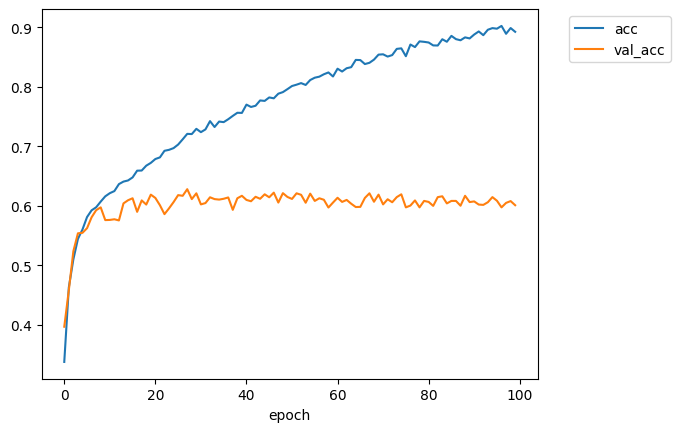

In [13]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
# First, define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(32, 32, 3))  # Input layer
x = tf.keras.layers.Flatten()(inputs)  # Flatten input into a 1D vector
x = tf.keras.layers.Dense(512, activation='sigmoid')(x)  # First hidden layer
x = tf.keras.layers.Dense(256, activation='sigmoid')(x)  # Second hidden layer
x = tf.keras.layers.Dense(128, activation='sigmoid')(x)  # Third hidden layer
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  # Output layer

# Define the model
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")

# Print a summary of the architecture
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''
my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs = 100
batch_size = 100
training_history = my_mlp_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    batch_size=batch_size
)

# COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)
display_training_curves(training_history)

**[QUESTION]** Try to find an optimal architecture without overfitting by using a regularization (or other) technique of your choice. The goal is to have a performance > 60% without overfitting after **20** epochs.


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 400)                 │       1,229,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 400)                 │           1,600 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 200)                 │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 75)                  │           7,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 75)                  │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 4)                   │             304 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,340,479 (5.11 MB)

 Trainable params: 1,338,929 (5.11 MB)

 Non-trainable params: 1,550 (6.05 KB)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - accuracy: 0.3282 - loss: 2.0853 - val_accuracy: 0.3080 - val_loss: 1.9203 - learning_rate: 3.0000e-04
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4461 - loss: 1.7097 - val_accuracy: 0.3491 - val_loss: 1.6750 - learning_rate: 3.0000e-04
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4868 - loss: 1.5955 - val_accuracy: 0.5040 - val_loss: 1.4729 - learning_rate: 3.0000e-04
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5074 - loss: 1.5352 - val_accuracy: 0.4951 - val_loss: 1.4609 - learning_rate: 3.0000e-04
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5337 - loss: 1.4644 - val_accuracy: 0.5560 - val_loss: 1.3626 - learning_rate: 3.0000e-04
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5382 - loss: 1.4367 - val_accuracy: 0.5487 - val_loss: 1.3630 - learning_rate: 3.0000e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5504

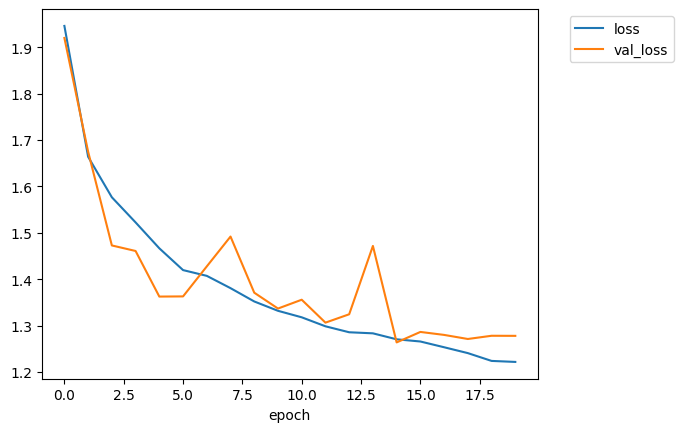

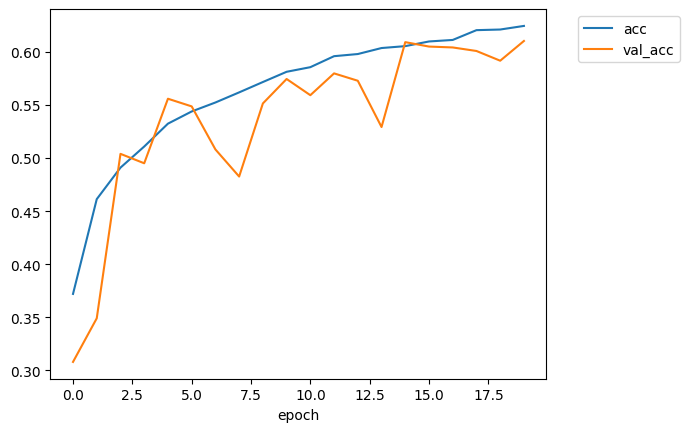

In [14]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# (1) DEFINE THE ARCHITECTURE OF MY MODEL
inputs = tf.keras.Input(shape=(32, 32, 3))  # Input layer
x = tf.keras.layers.Flatten()(inputs)

# First Dense layer
x = tf.keras.layers.Dense(
    400,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l1_l2(l1=5e-6, l2=1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout reduced to 0.2

# Second Dense layer
x = tf.keras.layers.Dense(
    200,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l1_l2(l1=5e-6, l2=1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout reduced to 0.2

# Third Dense layer
x = tf.keras.layers.Dense(
    100,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l1_l2(l1=5e-6, l2=1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout reduced to 0.2

# Fourth Dense layer (slightly larger)
x = tf.keras.layers.Dense(
    75,  # Increased from 50 to 75
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l1_l2(l1=5e-6, l2=1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout reduced to 0.2

# Output layer
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# Define the model
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS
my_mlp_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Learning rate reduced to 0.0003
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# (3) TRAIN THE MODEL WITHOUT DATA AUGMENTATION
nb_epochs = 20
batch_size = 512

training_history = my_mlp_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    batch_size=batch_size,
    callbacks=[reduce_lr]
)

# (4) COMPUTE ACCURACY
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

# Visualize training curves
display_training_curves(training_history)


# CONVOLUTIONAL NEURAL NETWORK (CNN) [12 pts]

## Build a first architecture [6 pts]

MLPs are great but CNNs should work better for our image classification problem...

For that, we will use new layers from TF.KERAS:
   - [tf.keras.layers.Conv2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) an example is:
```
l = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(l_input)
```
Here, we ask for 32 convolutional kernels of size [3,3]. By default the stride is set to '1' and the padding is 'valid'.

   - tf.keras.layers.MaxPooling2D() an example is:
```
l = tf.keras.layers.MaxPooling2D()(l_input)
```
By default the stride is set to '2' and the padding is 'valid'.



**[QUESTION]** With the default parameters of *Conv2D()*, do you expect to have the same shape for the output tensor?  

**[ANSWER]** No because by default the padding is 'valid' and not 'same', which means that the size of the output tensor will be smaller than the input one.

**[QUESTION]** With the default parameters of _MaxPooling2D()_, what do you expect on the shape of the output tensor?

**[ANSWER]** No, in this case the padding is 'valid' by default and the stride is set to 2, so we expect the output tensor to have a smaller shape (divided by 2).

**[QUESTION]** Try to build a first CNN model with this architecture:

```
x --> Conv2D (32 filters) ==> MaxPooling ==> Conv2D (64 filters) ==> MaxPooling ==> Flatten ==> Dense (4) --> ̂y
```

In [15]:
# (1) DEFINE THE ARCHITECTURE OF MY CNN MODEL
l_input = tf.keras.Input(shape=(32, 32, 3))  # Input layer (image size 32x32x3)

# First convolutional layer with 32 filters and MaxPooling
l = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(l_input)
l = tf.keras.layers.MaxPooling2D()(l)

# Second convolutional layer with 64 filters and MaxPooling
l = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(l)
l = tf.keras.layers.MaxPooling2D()(l)

# Flatten layer to convert 2D data to 1D
l = tf.keras.layers.Flatten()(l)

# Fully connected layer with 4 neurons (output layer)
l_output = tf.keras.layers.Dense(4, activation='softmax')(l)

# Define the model
my_cnn_model = tf.keras.Model(inputs=l_input, outputs=l_output, name="my_cnn_model")

# Print a summary of the architecture
my_cnn_model.summary()

# (2) COMPILE THE MODEL
my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) TRAIN THE MODEL
nb_epochs = 10
batch_size = 100
training_history_cnn = my_cnn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    batch_size=batch_size
)

# (4) EVALUATE THE MODEL
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │           9,220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,612 (111.77 KB)

 Trainable params: 28,612 (111.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4241 - loss: 1.2535 - val_accuracy: 0.6165 - val_loss: 0.9617
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6175 - loss: 0.9518 - val_accuracy: 0.6615 - val_loss: 0.8609
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6622 - loss: 0.8488 - val_accuracy: 0.6834 - val_loss: 0.8126
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6965 - loss: 0.7793 - val_accuracy: 0.6956 - val_loss: 0.7877
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7133 - loss: 0.7349 - val_accuracy: 0.7073 - val_loss: 0.7615
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7233 - loss: 0.7114 - val_accuracy: 0.7323 - val_loss: 0.7202
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7403 - loss: 0.6772 - val_accuracy: 0.7440 - val_loss: 0.6925
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7443 - loss: 0.6590 - val_accuracy: 0

**[QUESTION]** Display the training curves from your CNN model.


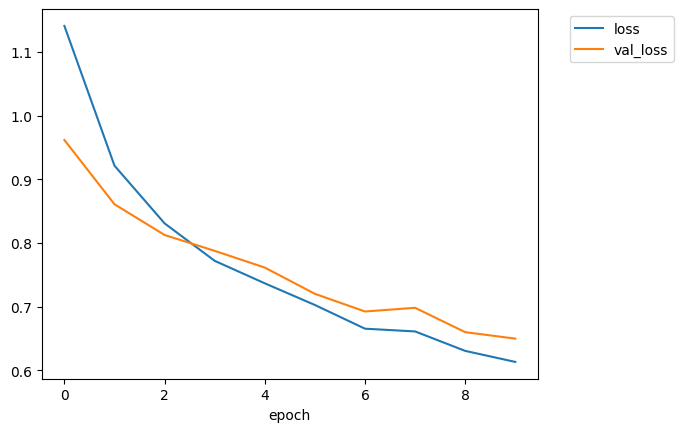

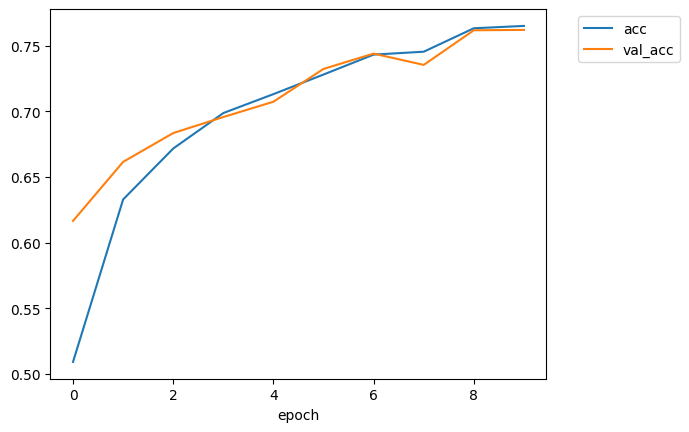

In [16]:
#Your code here
display_training_curves(training_history_cnn)

## Improvements and overfitting [6 pts]

**[QUESTION]** Use, the code of your last model and adapt it so that your model **OVERFITS**.

We need to see the overfitting issue on the training curve!

Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,916 (1.43 MB)

 Trainable params: 374,916 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4257 - loss: 1.2303 - val_accuracy: 0.6476 - val_loss: 0.8843
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6712 - loss: 0.8283 - val_accuracy: 0.7090 - val_loss: 0.7633
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7185 - loss: 0.7242 - val_accuracy: 0.7295 - val_loss: 0.7020
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7571 - loss: 0.6477 - val_accuracy: 0.7354 - val_loss: 0.6900
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7730 - loss: 0.5856 - val_accuracy: 0.7698 - val_loss: 0.6213
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7904 - loss: 0.5450 - val_accuracy: 0.7615 - val_loss: 0.6306
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8189 - loss: 0.4830 - val_accuracy: 0.7692 - val_loss: 0.6075
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8358 - loss: 0.4367 - val_accuracy: 

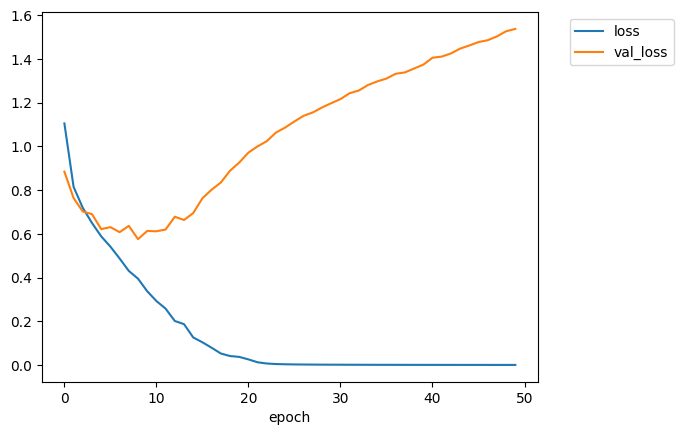

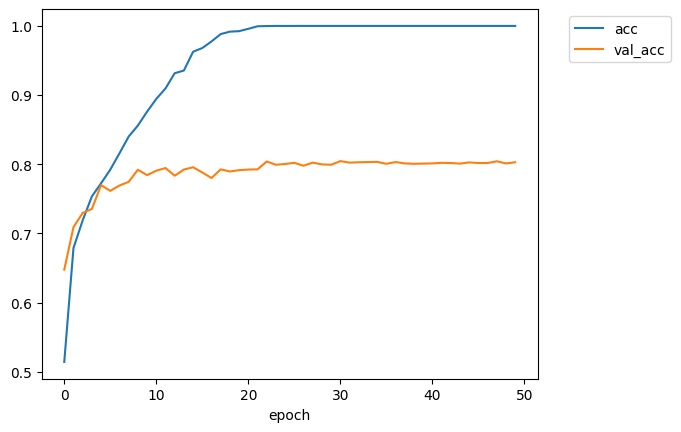

In [17]:
#Your code here
# (1) DEFINE THE ARCHITECTURE OF MY CNN MODEL
l_input = tf.keras.Input(shape=(32, 32, 3))  # Input layer (image size 32x32x3)

# First convolutional layer with 64 filters and MaxPooling
l = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(l_input)
l = tf.keras.layers.MaxPooling2D()(l)

# Second convolutional layer with 128 filters and MaxPooling
l = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu')(l)
l = tf.keras.layers.MaxPooling2D()(l)

# Second convolutional layer with 256 filters and MaxPooling
l = tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu')(l)
l = tf.keras.layers.MaxPooling2D()(l)

# Flatten layer to convert 2D data to 1D
l = tf.keras.layers.Flatten()(l)

# Fully connected layer with 4 neurons (output layer)
l_output = tf.keras.layers.Dense(4, activation='softmax')(l)

# Define the model
my_cnn_model = tf.keras.Model(inputs=l_input, outputs=l_output, name="my_cnn_model")

# Print a summary of the architecture
my_cnn_model.summary()

# (2) COMPILE THE MODEL
my_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# (3) TRAIN THE MODEL
nb_epochs = 50
batch_size = 100
training_history_cnn = my_cnn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    batch_size=batch_size
)

# (4) EVALUATE THE MODEL
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)
display_training_curves(training_history_cnn)

**[QUESTION]** Fix your overfitting issue with a technique of your choice.


Model: "my_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,428 (622.77 KB)

 Trainable params: 159,428 (622.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - accuracy: 0.2653 - loss: 1.7521 - val_accuracy: 0.3877 - val_loss: 1.3775
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.3700 - loss: 1.4312 - val_accuracy: 0.3866 - val_loss: 1.3779
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.3887 - loss: 1.3605 - val_accuracy: 0.4907 - val_loss: 1.2404
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.2252 - val_accuracy: 0.5012 - val_loss: 1.2324
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.4818 - loss: 1.2378 - val_accuracy: 0.5629 - val_loss: 1.1186
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5200 - loss: 1.2097 - val_accuracy: 0.5579 - val_loss: 1.1236
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.5349 - loss: 1.1597 - val_accuracy: 0.5848 - val_loss: 1.0625
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.5300 - loss: 1.2279 - val_accuracy: 0.5840 - val_loss: 1.0621
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.5848 - loss: 1.0689 - val_accuracy: 0.6290 - val_loss: 0.9741
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6400 - loss: 1.0742 - val_accuracy: 

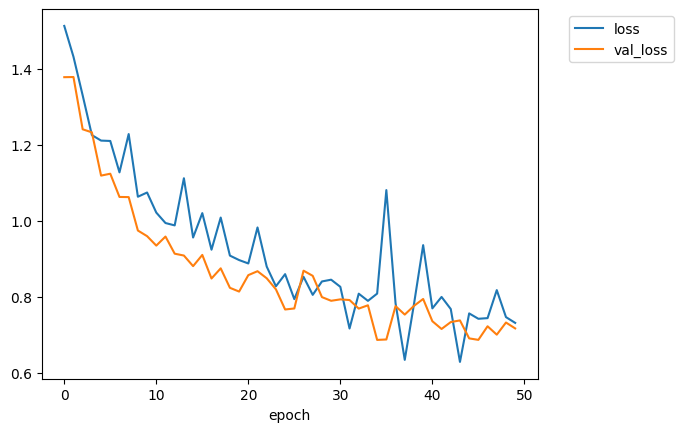

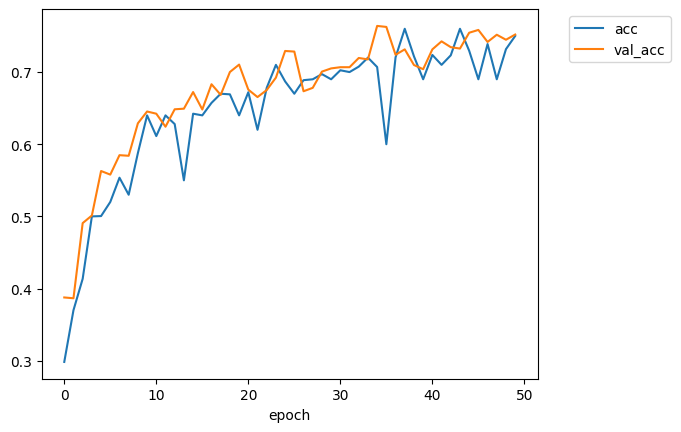

In [18]:
#Your code here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# (1) DEFINE THE ARCHITECTURE OF MY CNN MODEL
l_input = tf.keras.Input(shape=(32, 32, 3))  # Input layer (image size 32x32x3)

# First convolutional layer with 32 filters and MaxPooling
l = tf.keras.layers.Conv2D(
    32,
    kernel_size=3,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l2(1e-4)
)(l_input)
l = tf.keras.layers.MaxPooling2D()(l)
l = tf.keras.layers.Dropout(0.25)(l)  # Dropout added

# Second convolutional layer with 64 filters and MaxPooling
l = tf.keras.layers.Conv2D(
    64,
    kernel_size=3,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l2(1e-4)
)(l)
l = tf.keras.layers.MaxPooling2D()(l)
l = tf.keras.layers.Dropout(0.25)(l)  # Dropout added

# Third convolutional layer with 128 filters and MaxPooling
l = tf.keras.layers.Conv2D(
    128,
    kernel_size=3,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l2(1e-4)
)(l)
l = tf.keras.layers.MaxPooling2D()(l)
l = tf.keras.layers.Dropout(0.25)(l)  # Dropout added

# Flatten layer to convert 2D data to 1D
l = tf.keras.layers.Flatten()(l)

# Fully connected Dense layer with 128 neurons
l = tf.keras.layers.Dense(
    128,
    activation='relu',
    kernel_initializer='he_normal',
    kernel_regularizer=regularizers.l2(1e-4)
)(l)
l = tf.keras.layers.Dropout(0.5)(l)  # Dropout added

# Fully connected Dense layer with 4 neurons (output layer)
l_output = tf.keras.layers.Dense(4, activation='softmax')(l)

# Define the model
my_cnn_model = tf.keras.Model(inputs=l_input, outputs=l_output, name="my_cnn_model")
my_cnn_model.summary()

# (2) COMPILE THE MODEL
my_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# (3) APPLY DATA AUGMENTATION
data_augmentation = ImageDataGenerator(
    rotation_range=15,  # Randomly rotate images by up to 15 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
    horizontal_flip=True  # Randomly flip images horizontally
)

# Use the augmented data generator for training
train_generator = data_augmentation.flow(X_train, Y_train, batch_size=100)

# (4) TRAIN THE MODEL
nb_epochs = 50
training_history_cnn = my_cnn_model.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    epochs=nb_epochs,
    steps_per_epoch=len(X_train) // 100,
    batch_size=100
)

# (5) EVALUATE THE MODEL
loss_train, acc_train = my_cnn_model.evaluate(X_train, Y_train, batch_size=100)
loss_test, acc_test = my_cnn_model.evaluate(X_test, Y_test, batch_size=100)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

# Display training curves
display_training_curves(training_history_cnn)

[**QUESTION**] Regarding these experiences, compare MLP vs. CNN

[**ANSWER**]  Le CNN semble être bien plus efficace sur les images par rapport à un MLP, puisqu'il capte les relations spatiales entre les pixels grâce aux convolutions et au pooling. Le CNN semble également être un peu moins sensible à l'overfitting mais est plus complexe que le MLP, ce qui augmente le temps d'exécution des programmes.

# BONUS

In [ ]:
#If you have additional experiences, put it here
#Bonus content will be evaluated IF AND ONLY IF you completed this practical session (all questions & codes)